In [1]:
from db import databaseconnection 
import numpy as np
from ga import networkedgeneticalgorithm as nga
from membranesimulation import MembraneSimulation
#import parlammps
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx
from tools import vectools
import os
import tools
import copy
import random
import pprint
import k3d
import math
import time
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
pp = pprint.PrettyPrinter(indent=4)

In [2]:
#dbconn = databaseconnection.DatabaseConnection('../JUPYTER/DB/STORE/FIXED-ANGLE-LOWEPS8.db')
#dbconn = databaseconnection.DatabaseConnection('../JUPYTER/DB/STORE/FIXED-ANGLE-HIGHEPS15.db')
#dbconn = databaseconnection.DatabaseConnection('../JUPYTER/DB//////////Y2-FINAL.db')
dbconn = databaseconnection.DatabaseConnection('../JUPYTER/DB/GP5.db')

In [3]:
dbconn.whatSessions()

[1]

In [ ]:
data = dbconn.loadSession('2018-06-12 13:57:18')

In [5]:
#This is here to avoid breaking literally everything, getSession() loads the raw objects and is much much neater

data = dbconn.loadSession('1')
print('loaded data:{}'.format(data.keys()))

/storage/users/mvuyyuru/optihedron/venv/lib/python2.7/site-packages/sqlalchemy/sql/sqltypes.py:603: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


loaded data:['metrics', 'individuals', 'genealogy']


In [6]:
#A much better way of loading the data from the db
session = dbconn.getSession(1)
individuals = session.getIndividualsList()

In [7]:
dbconn.close()

### Helper Fns.

In [8]:
#fitness given genome
def genomeFitness(genome):
    for individual in data['individuals']:
        if np.array_equal(individual['genome'], genome):
            return individual['fitness']
    return -1

In [9]:
def trimLigands(inds):
    #trim ligands with eps=0 for tiled NP model
    inds_tmp = []
    for ind in inds:
        ligands_tmp = []
        for ligand in ind['phenome'].particle.ligands:
            if ligand.eps != 0:
                ligands_tmp.append(ligand)
        ind_tmp = copy.deepcopy(ind)
        ind_tmp['phenome'].particle.ligands = ligands_tmp
        inds_tmp.append(ind_tmp)
    return inds_tmp

In [10]:
def evaluateSample(nps, gens, inds, rs, RUNTIME=25000, TIMESTEP=0.01, wd_out = 'wetlab/out', wd_run = 'wetlab/run',nprocs=2, timeout=999999, silent=False, DUMP=1000):    
    wd = ''
    for np,gen,ind in zip(nps,gens,inds):
        for rs_i in range(rs):
            simName = str(gen) + '_' + str(ind) + '_' +str(rs_i)
            sim = MembraneSimulation(
                'sim_'+simName,
                np.particle,
                RUNTIME,
                TIMESTEP,                 
                os.path.join(wd, wd_out),
                os.path.join(wd, wd_run),
                os.path.join(wd,'mem/template/data.template'),
                os.path.join(wd,'mem/template/in.template'),
                rAxis=vectools.randomUnitVector(),
                rAmount=random.uniform(1.571,3.141),
                dumpres=DUMP
                )
            sim.saveFiles()
            scriptPath=os.path.join(sim.filedir,sim.scriptName)
            outFilePath = os.path.join(sim.outdir,sim.outName)
            parlammps.runSim(scriptPath,nprocs,timeout,silent)                        
            sim.postProcessOutput(outFilePath)                        

In [11]:
def greatArcDist(Ang1, Ang2, rad=4):
    #Ang = (PolarAng,AziAng)
    #https://math.stackexchange.com/questions/231221/great-arc-distance-between-two-points-on-a-unit-sphere
    arcDist=rad*(np.arccos((np.cos(Ang1[0])*np.cos(Ang2[0]))+((np.sin(Ang1[0])*np.sin(Ang2[0]))*(np.cos(Ang1[1]-Ang2[1])))))
    return arcDist

In [12]:
def cluster(ligands, trimmingDist, silent=True):
    if not silent:
        startTime = time.time()
    #print(greatArcDist((0,0), ((3.14/15.0),0))) #bad at small distances, correct should be 0.8377 but returns 0.8373, willing to accept +- 0.001

    ligandsTmp = copy.deepcopy(ligands)

    clusters = []
    while ligandsTmp:    
        #print('progress: {}/{}'.format(len(ligandsTmp),len(ligands)))
        nextSeedQueue = [ligandsTmp[0]]    

        clusterTmp = []
        clusterTmp.append(ligandsTmp[0])
        del ligandsTmp[0]
        while nextSeedQueue:
            seed = nextSeedQueue.pop()
            for ligand in ligandsTmp:
                if greatArcDist((seed.polAng, seed.aziAng),(ligand.polAng,ligand.aziAng)) <= trimmingDist:                
                    nextSeedQueue.append(ligand)
                    clusterTmp.append(ligand)
                    ligandsTmp.remove(ligand)
        clusters.append(clusterTmp)                  
    if not silent:
        print('ligands: {}'.format(len(ligands)))
        print('clusters: {}'.format(len(clusters)))
        print('clustered in {}s'.format(time.time()-startTime))
    return clusters

In [13]:
def avgClusterDist(clusters, silent=True):
    ###find average position of each cluster
    if not silent:
        startTime = time.time()
    avgClusterPos = []    
    for i in clusters:
        ligandCount = 0
        totalPol = 0
        totalAzi = 0
        for j in i:
            totalPol += j.polAng
            totalAzi += j.aziAng
            ligandCount += 1.0
        avgClusterPos.append(((totalPol/ligandCount),(totalAzi/ligandCount)))
    ###
    ###find distances to next nearest for each
    avgClusterNxtDistances = []
    for i in avgClusterPos:
        tmp = []
        for j in avgClusterPos:
            if i != j:
                tmp.append(greatArcDist(i,j))
        avgClusterNxtDistances.append(np.min(tmp))
#     avgClusterNxtDistances = []    
#     avgClusterPosTmp = copy.deepcopy(avgClusterPos)
#     while avgClusterPosTmp:
#         cClusterPos = avgClusterPosTmp.pop()        
#         if len(avgClusterPosTmp) > 0:
#             tmp = []
#             for i in avgClusterPosTmp:
#                 if i != cClusterPos:
#                     tmp.append(greatArcDist(i,cClusterPos))
#             avgClusterNxtDistances.append(np.min(tmp))
    ###
    ###return an average of those distances   
    if not silent:
        print('avg cluster distance found in {}s'.format(time.time() - startTime))    
    return sum(avgClusterNxtDistances)/len(avgClusterNxtDistances)
    ###

In [14]:
def buildLigandNetwork(ligands, silent=True):
    if not silent:
        startTime = time.time()
    G=networkx.Graph()
    
    nIndex = 1
    for i in ligands:
        if i.eps > 0.0:
            G.add_node(nIndex,weight=i.eps,polAng=i.polAng,aziAng=i.aziAng)
        nIndex += 1
    
    iIndex = 1
    for i in ligands:
        jIndex = 1
        for j in ligands:
            if i < j:
                cartDist = 1.0/greatArcDist((i.polAng,i.aziAng),(j.polAng,j.aziAng))
                #affDist = abs(i.eps - j.eps)
                if i.eps > 0.0 and j.eps > 0.0:
                    G.add_edge(iIndex, jIndex, weight=cartDist)
            jIndex += 1
        iIndex += 1
    return G

In [15]:
def avgLigandDist(ligands, silent=True):
    if not silent:
        startTime = time.time()
    LigandNxtDistances = []
    for i in ligands:
        tmp = []
        for j in ligands:
            if i != j:
                tmp.append(greatArcDist((i.polAng,i.aziAng),(j.polAng,j.aziAng)))
        LigandNxtDistances.append(np.min(tmp))
#     ligandsTmp = copy.deepcopy(ligands)
#     while ligandsTmp:
#         cLigand = ligandsTmp.pop()
#         if len(ligandsTmp) > 0:
#             tmp = []
#             for i in ligandsTmp:
#                 if i != cLigand:
#                     tmp.append(greatArcDist((i.polAng,i.aziAng),(cLigand.polAng,cLigand.aziAng)))
#             LigandNxtDistances.append(np.min(tmp))
    if not silent:
        print('avg ligand distance found in {}s'.format(time.time() - startTime))
    return sum(LigandNxtDistances)/len(LigandNxtDistances)

In [16]:
def numNN(ligands, cutoff):
    #number of ligands that are nearest neighbours ligand-wise
    numNNs = []
    for i in ligands:
        numNN_i = 0
        for j in ligands:
            if i != j:
                if greatArcDist((i.polAng,i.aziAng),(j.polAng,j.aziAng)) <= cutoff:
                    numNN_i += 1
        numNNs.append(numNN_i)
    return numNNs

In [17]:
def numMinNumNN(ligands,cutoff,minligands):
    #number of ligands which have at least minligands ligands that are within cutoff range ligand-wise
    numMinNumNNs = 0
    for i in ligands:
        numNNs = 0
        for j in ligands:
            if i != j:
                if greatArcDist((i.polAng,i.aziAng),(j.polAng,j.aziAng)) <= cutoff:
                    numNNs += 1
        if numNNs >= minligands:
            numMinNumNNs += 1
    return numMinNumNNs

In [18]:
def totalEps(ligands):
    return np.sum([ligand.eps for ligand in ligands])    

In [19]:
def plotNP(ligands=None, rad=4):
    fig = plt.figure(figsize=(40.0,16.0))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")

    u, v = np.mgrid[0:2*np.pi:25j, 0:np.pi:25j]
    x = np.cos(u)*np.sin(v)*rad
    y = np.sin(u)*np.sin(v)*rad
    z = np.cos(v)*rad
    #ax.scatter(x, y, z, color="r", alpha=0.2)    
    ax.plot_wireframe(x, y, z, color="r", alpha=0.2)
    if ligands:
        for ligand in ligands:
            v = tools.vectools.polarToCartesianVector(rad,ligand.polAng,ligand.aziAng)
            ax.scatter(v[0],v[1],v[2],s=[200]*len(ligands),color="g")

In [25]:
def formFactor(ligands):
    totalLigands = float(len(ligands))
    spottyLigands = 0    
    lineyLigands = 0    
    patchyLigands = 0

    #counting liney ligands
    for j in ligands:
        NNcount = 0
        NNlist = []
        for k in ligands:        
            if j != k:
                dist = greatArcDist((j.polAng,j.aziAng),(k.polAng,k.aziAng))
                if dist <= 2.0:
                    NNcount += 1
                    NNlist.append(k)
        if NNcount == 2:#if it has 2 NNs                
            dist = greatArcDist((NNlist[0].polAng,NNlist[0].aziAng),(NNlist[1].polAng,NNlist[1].aziAng))
            if not dist <= 2.0:#and the NNs are not each other's NN
                lineyLigands += 1                              
        if NNcount == 1:
            lineyLigands += 1  
                
                
    
    #counting spotty ligands
    for j in ligands:
        NNcount = 0
        for k in ligands:            
            if j != k:
                dist = greatArcDist((j.polAng,j.aziAng),(k.polAng,k.aziAng))
                if dist <= 2.0:
                    NNcount += 1
        if NNcount == 0:
            spottyLigands += 1
    
    #counting patchy ligands
    patchyLigands = totalLigands - spottyLigands - lineyLigands
    
    return float(patchyLigands)/totalLigands, float(lineyLigands)/totalLigands, float(spottyLigands)/totalLigands

# GA Metrics

In [ ]:
#print(data['metrics'])

fitAvg = [metric['avg'] for metric in data['metrics']]
fitMin = [metric['min'] for metric in data['metrics']]
fitMax = [metric['max'] for metric in data['metrics']]
plt.plot(fitAvg, '.',label='Average Fitness');
plt.plot(fitMax, '.',label='Max Fitness');
plt.plot(fitMin, '.',label='Min Fitness');
plt.xlabel('generation number')
plt.ylabel('fitness')
plt.legend();

# Genealogy

In [ ]:
plt.rcParams['figure.figsize'] = (40.0, 16.0)
graph = networkx.DiGraph(data['genealogy']['tree'])
graph = graph.reverse()
colors = [genomeFitness(data['genealogy']['history'][i]) for i in graph]
positions = networkx.drawing.nx_agraph.graphviz_layout(graph, prog="dot")
networkx.draw(graph, positions, node_color = colors, s=40, cmap=plt.cm.Spectral)
fits = [ individual['fitness'] for individual in data['individuals']]
sm = plt.cm.ScalarMappable(cmap=plt.cm.Spectral, norm=plt.Normalize(vmin=float(min(fits)), vmax=float(max(fits))))
sm._A = []
plt.colorbar(sm)
plt.savefig('genealogy.png')
plt.show()

# Generate Local Samples

In [ ]:
#generate your samples
hof = []
for i in data['individuals']:
    if i['fitness'] == 400.0: #400 means all rotations budded in!
        hof.append(i)

# #best performers in gen X (gen=X)
# curr_best_fitness = -1
# best = None
# genS = 29
# for i in data['individuals']:
#     if i['gen'] == genS:
#         if i['fitness'] > curr_best_fitness:    
#             best = i
#             curr_best_fitness = i['fitness']
# for i in data['individuals']:
#     if i['gen'] == genS:
#         if i ['fitness'] == curr_best_fitness:            
#             hof.append(i)
# #hof.append(best)        
    
print('samples length:{}'.format(len(hof)))
print('samples generations:{}'.format([i['gen'] for i in hof]))

In [ ]:
phenomes = [i['phenome'] for i in hof]
gens = [i['gen'] for i in hof]
inds = [i['ind'] for i in hof]
evaluateSample(phenomes, gens, inds,rs=2,nprocs=4,silent=False)
#evaluateSample(phenomes, gens, inds,rs=2,nprocs=4,silent=False,DUMP=250)
#evaluateSample(phenomes, gens, inds,rs=1,silent=True,RUNTIME=100)

# Ligand Clustering

In [ ]:
# clusters = cluster(hof[0]['phenome'].particle.ligands,1.8,silent=False)
# plotNP(clusters[9])

In [ ]:
#NNcutoff = 1.345 #for int. range 1.8
NNcutoff = 1.559 #for int. range 2.0
for i in data['individuals']:    
    i['ligand_clusters'] = cluster(i['phenome'].particle.ligands,NNcutoff,silent=True)

In [21]:
##for tiled NP, removed ligands with eps=0
data['individuals'] = trimLigands(data['individuals'])

## v. Gen

In [22]:
#individuals sorted by gen
ind_tmp = copy.deepcopy(data['individuals'])
ind_tmp.sort(key=lambda x:x['gen'])

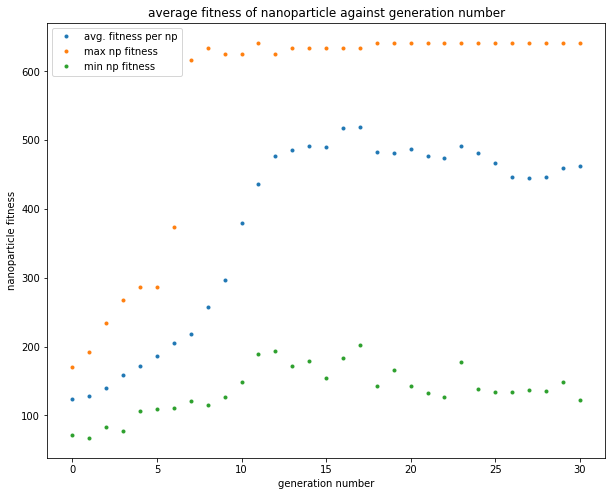

In [23]:
#fitness avg+dev, max
plt.rcParams['figure.figsize'] = (10.0, 8.0)

totalFitness = 0
totalNPCount = 0
currentGen = 0
genNumberFitnessAverage= []
fitnessMax = -1
fitnessMin = 9999999
fitnessMinAll = []
fitnessMaxAll = []

err = []#
for i in ind_tmp:
    if i['gen'] != currentGen:      
        genNumberFitnessAverage.append(((currentGen),(float(totalFitness)/totalNPCount)))
        currentGen = i['gen']        
        totalFitness = float(i['fitness'])
        totalNPCount = 1
        fitnessMinAll.append(fitnessMin)
        fitnessMaxAll.append(fitnessMax)     
        fitnessMax = -1
        fitnessMin = 9999999
        if float(i['fitness']) > fitnessMax:
            fitnessMax = float(i['fitness'])
        if float(i['fitness']) < fitnessMin:
            fitnessMin = float(i['fitness'])
    else:        
        totalFitness += float(i['fitness'])
        totalNPCount += 1
        if float(i['fitness']) > fitnessMax:
            fitnessMax = float(i['fitness'])
        if float(i['fitness']) < fitnessMin:
            fitnessMin = float(i['fitness'])

        
plt.plot([i[0] for i in genNumberFitnessAverage],[i[1] for i in genNumberFitnessAverage],'.',label='avg. fitness per np')    
plt.plot([i[0] for i in genNumberFitnessAverage], fitnessMaxAll, '.', label='max np fitness')#
plt.plot([i[0] for i in genNumberFitnessAverage], fitnessMinAll, '.', label='min np fitness')#
plt.xlabel('generation number')
plt.ylabel('nanoparticle fitness')
plt.title('average fitness of nanoparticle against generation number')
plt.legend();

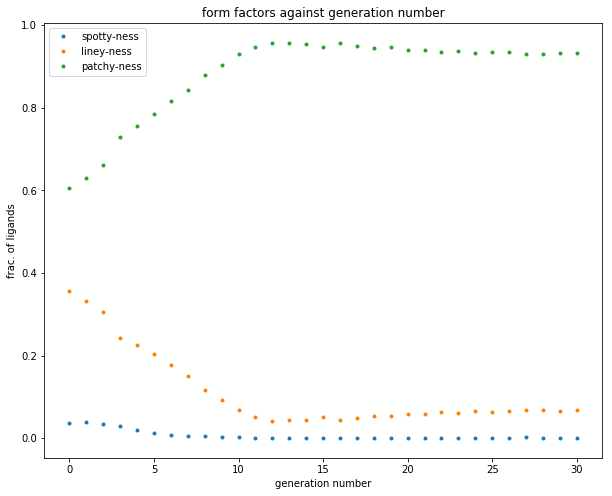

In [27]:
#form factor by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalSpotty = 0
totalLiney = 0
totalPatchy = 0
totalNPCount = 0
currentGen = 0
genSpottyAvg = []
genLineyAvg = []
genPatchyAvg = []


for i in ind_tmp:
    if i['gen'] != currentGen:      
        genSpottyAvg.append(((currentGen),(float(totalSpotty)/totalNPCount)))
        genLineyAvg.append(((currentGen),(float(totalLiney)/totalNPCount)))
        genPatchyAvg.append(((currentGen),(float(totalPatchy)/totalNPCount)))
        
        currentGen = i['gen']
        totalPatchy, totalLiney, totalSpotty = formFactor(i['phenome'].particle.ligands)        
        totalNPCount = 1
    else:
        totalPatchyAdd, totalLineyAdd, totalSpottyAdd = formFactor(i['phenome'].particle.ligands)
        totalPatchy += totalPatchyAdd
        totalLiney += totalLineyAdd
        totalSpotty += totalSpottyAdd    
        totalNPCount += 1

    
plt.plot([i[0] for i in genSpottyAvg],[i[1] for i in genSpottyAvg],'.',label='spotty-ness')
plt.plot([i[0] for i in genLineyAvg],[i[1] for i in genLineyAvg],'.',label='liney-ness')
plt.plot([i[0] for i in genPatchyAvg],[i[1] for i in genPatchyAvg],'.',label='patchy-ness') 
plt.xlabel('generation number')
plt.ylabel('frac. of ligands')
plt.title('form factors against generation number')
plt.legend();

In [ ]:
#number of ligand by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberLigands = 0
totalNPCount = 0
currentGen = 0
genNumberLigandsAverage= []
for i in ind_tmp:
    if i['gen'] != currentGen:      
        genNumberLigandsAverage.append(((currentGen),(float(totalNumberLigands)/totalNPCount)))
        currentGen = i['gen']
        totalNumberLigands = len(i['phenome'].particle.ligands)        
        totalNPCount = 1
    else:
        totalNumberLigands += len(i['phenome'].particle.ligands)
        totalNPCount += 1
    
plt.plot([i[0] for i in genNumberLigandsAverage],[i[1] for i in genNumberLigandsAverage],'.',label='avg. num ligands per np')    
plt.xlabel('generation number')
plt.ylabel('average number of ligands')
plt.title('average number of ligands per nanoparticle against generation number')
plt.legend();

In [ ]:
#number of ligand clusters by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberClusters = 0
totalNPCount = 0
currentGen = 0
genNumberClustersAverage= []
for i in ind_tmp:
    if i['gen'] != currentGen:    
        genNumberClustersAverage.append(((currentGen),(float(totalNumberClusters)/totalNPCount)))
        currentGen = i['gen']
        totalNumberClusters = float(len(i['ligand_clusters']))
        totalNPCount = 1
    else:
        totalNumberClusters += float(len(i['ligand_clusters']))
        totalNPCount += 1
    
plt.plot([i[0] for i in genNumberClustersAverage],[i[1] for i in genNumberClustersAverage],'.',label='cluster cutoff: {} (ligand interaction range)'.format(NNcutoff))    
plt.xlabel('generation number')
plt.ylabel('average number of ligand clusters')
plt.title('average number of ligand clusters per nanoparticle against generation number')
plt.legend();

In [ ]:
#number of ligand clusters by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalClusterLigandAvg = 0
totalNPCount = 0
currentGen = 0
genNumberClusterLigandAvgAverage= []
for i in ind_tmp:
    if i['gen'] != currentGen:    
        genNumberClusterLigandAvgAverage.append(((currentGen),(totalClusterLigandAvg/totalNPCount)))
        currentGen = i['gen']
        totalClusterLigandAvg = float(len(i['phenome'].particle.ligands))/float(len(i['ligand_clusters']))        
        totalNPCount = 1
    else:                
        totalClusterLigandAvg += float(len(i['phenome'].particle.ligands))/float(len(i['ligand_clusters']))        
        totalNPCount += 1
    
plt.plot([i[0] for i in genNumberClusterLigandAvgAverage],[i[1] for i in genNumberClusterLigandAvgAverage],'.',label='cluster cutoff: {} (ligand interaction range)'.format(NNcutoff))    
plt.xlabel('generation number')
plt.ylabel('average number of ligands in each cluster')
plt.title('average number of ligands in each cluster per nanoparticle against generation number')
plt.legend();

In [ ]:
#avg distance to next ligand by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNeighLigandDistAvg = 0
totalNPCount = 0
currentGen = 0
genNumberNeighLigandDistAverage= []
for i in ind_tmp:
    if i['gen'] != currentGen:            
        genNumberNeighLigandDistAverage.append(((currentGen),(totalNeighLigandDistAvg/totalNPCount)))
        currentGen = i['gen']
        totalNeighLigandDistAvg = avgLigandDist(i['phenome'].particle.ligands)        
        totalNPCount = 1
    else:                        
        totalNeighLigandDistAvg += avgLigandDist(i['phenome'].particle.ligands)        
        totalNPCount += 1
    
plt.plot([i[0] for i in genNumberNeighLigandDistAverage],[i[1] for i in genNumberNeighLigandDistAverage],'.',label='avg. dist. to next nearest ligand')    
plt.xlabel('generation number')
plt.ylabel('average distance to next nearest ligand')
plt.title('average distance to next nearest ligand per nanoparticle against generation number')
plt.legend();

In [ ]:
#avg distance to next ligand cluster by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNeighClustDistAvg = 0
totalNPCount = 0
currentGen = 0
genNumberNeighClustDistAverage= []
for i in ind_tmp:
    if i['gen'] != currentGen:            
        genNumberNeighClustDistAverage.append(((currentGen),(totalNeighClustDistAvg/totalNPCount)))
        currentGen = i['gen']
        totalNeighClustDistAvg = avgClusterDist(i['ligand_clusters'])                
        totalNPCount = 1
    else:                        
        totalNeighClustDistAvg += avgClusterDist(i['ligand_clusters'])        
        totalNPCount += 1
    
plt.plot([i[0] for i in genNumberNeighClustDistAverage],[i[1] for i in genNumberNeighClustDistAverage],'.',label='cluster cutoff: {} (ligand interaction range)'.format(NNcutoff))    
plt.xlabel('generation number')
plt.ylabel('average distance to next nearest cluster')
plt.title('average distance to next nearest cluster per nanoparticle against generation number')
plt.legend();

In [ ]:
#avg total ligand affinity by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalAffinity = 0.0
totalNPCount = 0.0
currentGen = 0.0
genTotalAffinityAverage = []
for i in ind_tmp:
    if i['gen'] != currentGen:
        genTotalAffinityAverage.append((currentGen, totalAffinity/totalNPCount))
        currentGen = i['gen']
        totalAffinity = totalEps(i['phenome'].particle.ligands)
        totalNPCount = 1
    else:
        totalAffinity += totalEps(i['phenome'].particle.ligands)
        totalNPCount += 1
plt.plot([i[0] for i in genTotalAffinityAverage], [i[1] for i in genTotalAffinityAverage],'.',label='avg. total aff. of ligands per np')
plt.xlabel('generation number')
plt.ylabel('average total affinity of ligands')
plt.title('average total affinity of ligands per nanoparticle against generation number')
plt.legend();

In [ ]:
#avg number of nearest neighbours by gen
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalAvgNumberNN = 0.0
totalNPCount = 0.0
currentGen = 0.0
genTotalAvgNumberNNAverage = []
for i in ind_tmp:
    if i['gen'] != currentGen:
        genTotalAvgNumberNNAverage.append((currentGen, totalAvgNumberNN/totalNPCount))
        currentGen = i['gen']
        totalAvgNumberNN = np.average(numNN(i['phenome'].particle.ligands, NNcutoff))    
        totalNPCount = 1
    else:
        totalAvgNumberNN += np.average(numNN(i['phenome'].particle.ligands, NNcutoff))        
        totalNPCount += 1
plt.plot([i[0] for i in genTotalAvgNumberNNAverage], [i[1] for i in genTotalAvgNumberNNAverage],'.',label='avg. num. ligands within NN cutoff {}'.format(NNcutoff))
plt.xlabel('generation number')
plt.ylabel('average number of ligand neighbours')
plt.title('average number of ligand neighbours per nanoparticle against generation number')
plt.legend();

In [ ]:
#avg number of ligands with 3 or more neighbours
NNcount = 3
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberLigands = 0.0
totalNPCount = 0.0
currentGen = 0.0
genTotalNumberLigandsAverage = []
for i in ind_tmp:
    if i['gen'] != currentGen:
        genTotalNumberLigandsAverage.append((currentGen, totalNumberLigands/totalNPCount))        
        currentGen = i['gen']
        totalNumberLigands = float(numMinNumNN(i['phenome'].particle.ligands, NNcutoff, NNcount))
        totalNPCount = 1
    else:
        totalNumberLigands += float(numMinNumNN(i['phenome'].particle.ligands, NNcutoff, NNcount))
        totalNPCount += 1
plt.plot([i[0] for i in genTotalNumberLigandsAverage], [i[1] for i in genTotalNumberLigandsAverage],'.',label='avg. num. ligands with {} or more neighbours'.format(NNcount))
plt.xlabel('generation number')
plt.ylabel('average number of ligands with {} or more neighbours'.format(NNcount))
plt.title('average number of ligands with {} or more neighbours per nanoparticle against generation number'.format(NNcount))
plt.legend();

## v. Fitness

In [28]:
#individuals sorted by fitness
ind_tmp = copy.deepcopy(data['individuals'])
ind_tmp.sort(key=lambda x:x['fitness'])

In [29]:
fitInt = 1.0 #fitness intervals

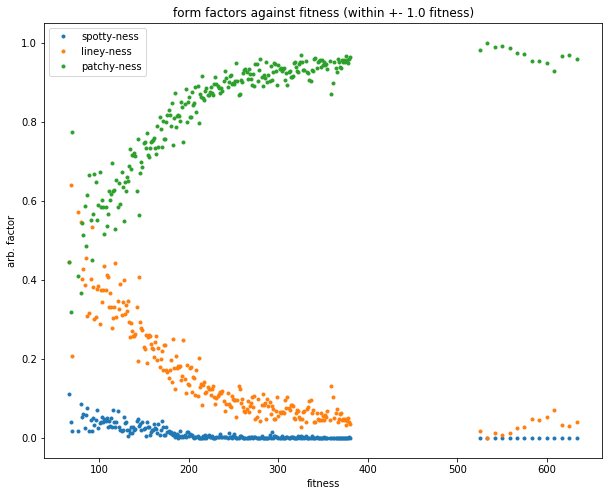

In [32]:
#form factor by fitness
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberLigands = 0
totalSpotty = 0
totalLiney = 0
totalPatchy = 0
totalNPCount = 0
currentFitness = ind_tmp[0]['fitness']
genSpottyAvg = []
genLineyAvg = []
genPatchyAvg = []


for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > fitInt:                      
        genSpottyAvg.append(((currentFitness),(float(totalSpotty)/totalNPCount)))
        genLineyAvg.append(((currentFitness),(float(totalLiney)/totalNPCount)))
        genPatchyAvg.append(((currentFitness),(float(totalPatchy)/totalNPCount)))
        
        currentFitness = i['fitness']        
        totalNumberLigands = len(i['phenome'].particle.ligands)        
          
        totalPatchy, totalLiney, totalSpotty = formFactor(i['phenome'].particle.ligands)        
        totalNPCount = 1
        
        
    else:
        totalPatchyAdd, totalLineyAdd, totalSpottyAdd = formFactor(i['phenome'].particle.ligands)
        totalPatchy += totalPatchyAdd
        totalLiney += totalLineyAdd
        totalSpotty += totalSpottyAdd    
        totalNPCount += 1


plt.plot([i[0] for i in genSpottyAvg],[i[1] for i in genSpottyAvg],'.',label='spotty-ness')
plt.plot([i[0] for i in genLineyAvg],[i[1] for i in genLineyAvg],'.',label='liney-ness')
plt.plot([i[0] for i in genPatchyAvg],[i[1] for i in genPatchyAvg],'.',label='patchy-ness')
plt.xlabel('fitness')
plt.ylabel('arb. factor'.format(fitInt))
plt.title('form factors against fitness (within +- {} fitness)'.format(fitInt))
plt.legend();

In [ ]:
#number of ligand by fitness
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberLigands = 0
totalNPCount = 0
currentFitness = ind_tmp[0]['fitness']
fitnessNumberLigandsAverage= []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:                      
        fitnessNumberLigandsAverage.append(((currentFitness),(float(totalNumberLigands)/totalNPCount)))
        currentFitness = i['fitness']
        totalNumberLigands = len(i['phenome'].particle.ligands)        
        totalNPCount = 1
    else:
        totalNumberLigands += len(i['phenome'].particle.ligands)
        totalNPCount += 1
    
plt.plot([i[0] for i in fitnessNumberLigandsAverage],[i[1] for i in fitnessNumberLigandsAverage],'.',label='avg. num ligands per np')    
plt.xlabel('fitness')
plt.ylabel('average number of ligands (within +- 5 fitness)')
plt.title('average number of ligands per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#number of ligand clusters by fitness
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberClusters = 0
totalNPCount = 0
currentFitness = ind_tmp[0]['fitness']
fitnessNumberClustersAverage= []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:    
        fitnessNumberClustersAverage.append(((currentFitness),(float(totalNumberClusters)/totalNPCount)))
        currentFitness = i['fitness']
        totalNumberClusters = len(i['ligand_clusters'])
        totalNPCount = 1
    else:
        totalNumberClusters += len(i['ligand_clusters'])
        totalNPCount += 1
    
plt.plot([i[0] for i in fitnessNumberClustersAverage],[i[1] for i in fitnessNumberClustersAverage],'.',label='cluster cutoff: {} (ligand interaction range)'.format(NNcutoff))    
plt.xlabel('fitness')
plt.ylabel('average number of ligand clusters (within +- 5 fitness)')
plt.title('average number of ligand clusters per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#number of ligand clusters by fitness
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalClusterLigandAvg = 0
totalNPCount = 0
currentFitness = ind_tmp[0]['fitness']
fitnessNumberClusterLigandAvgAverage= []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:    
        fitnessNumberClusterLigandAvgAverage.append(((currentFitness),(totalClusterLigandAvg/totalNPCount)))
        currentFitness = i['fitness']
        totalClusterLigandAvg = float(len(i['phenome'].particle.ligands))/float(len(i['ligand_clusters']))        
        totalNPCount = 1
    else:                
        totalClusterLigandAvg += float(len(i['phenome'].particle.ligands))/float(len(i['ligand_clusters']))        
        totalNPCount += 1
    
plt.plot([i[0] for i in fitnessNumberClusterLigandAvgAverage],[i[1] for i in fitnessNumberClusterLigandAvgAverage],'.',label='cluster cutoff: {} (ligand interaction range)'.format(NNcutoff))    
plt.xlabel('fitness')
plt.ylabel('average number of ligands in each cluster (within +- 5 fitness)')
plt.title('average number of ligands in each cluster per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#avg distance to next ligand
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNeighLigandDistAvg = 0
totalNPCount = 0
currentFitness = ind_tmp[0]['fitness']
fitnessNumberNeighLigandDistAverage= []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:            
        fitnessNumberNeighLigandDistAverage.append(((currentFitness),(totalNeighLigandDistAvg/totalNPCount)))
        currentFitness = i['fitness']
        totalNeighLigandDistAvg = avgLigandDist(i['phenome'].particle.ligands)        
        totalNPCount = 1
    else:                        
        totalNeighLigandDistAvg += avgLigandDist(i['phenome'].particle.ligands)        
        totalNPCount += 1
    
plt.plot([i[0] for i in fitnessNumberNeighLigandDistAverage],[i[1] for i in fitnessNumberNeighLigandDistAverage],'.',label='avg. dist. to next nearest ligand')    
plt.xlabel('fitness')
plt.ylabel('average distance to next nearest ligand (within +- 5 fitness)')
plt.title('average distance to next nearest ligand per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#avg distance to next ligand cluster
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNeighClustDistAvg = 0
totalNPCount = 0
currentFitness = ind_tmp[0]['fitness']
fitnessNumberNeighClustDistAverage= []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:            
        fitnessNumberNeighClustDistAverage.append(((currentFitness),(totalNeighClustDistAvg/totalNPCount)))
        currentFitness = i['fitness']
        totalNeighClustDistAvg = avgClusterDist(i['ligand_clusters'])                
        totalNPCount = 1
    else:                        
        totalNeighClustDistAvg += avgClusterDist(i['ligand_clusters'])        
        totalNPCount += 1
    
plt.plot([i[0] for i in fitnessNumberNeighClustDistAverage],[i[1] for i in fitnessNumberNeighClustDistAverage],'.',label='cluster cutoff: {} (ligand interaction range)'.format(NNcutoff))    
plt.xlabel('fitness')
plt.ylabel('average distance to next nearest cluster (within +- 5 fitness)')
plt.title('average distance to next nearest cluster per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#avg total ligand affinity by fitness
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalAffinity = 0.0
totalNPCount = 0.0
currentFitness = ind_tmp[0]['fitness']
fitnessTotalAffinityAverage = []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:
        fitnessTotalAffinityAverage.append((currentFitness, totalAffinity/totalNPCount))
        currentFitness = i['fitness']
        totalAffinity = totalEps(i['phenome'].particle.ligands)
        totalNPCount = 1
    else:
        totalAffinity += totalEps(i['phenome'].particle.ligands)
        totalNPCount += 1
plt.plot([i[0] for i in fitnessTotalAffinityAverage], [i[1] for i in fitnessTotalAffinityAverage],'.',label='avg. total aff. of ligands per np')
plt.xlabel('fitness')
plt.ylabel('average total affinity of ligands (within +- 5 fitness)')
plt.title('average total affinity of ligands per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#avg number of nearest neighbours by fitness
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalAvgNumberNN = 0.0
totalNPCount = 0.0
currentFitness = ind_tmp[0]['fitness']
fitnessTotalAvgNumberNNAverage = []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:
        fitnessTotalAvgNumberNNAverage.append((currentFitness, totalAvgNumberNN/totalNPCount))
        currentFitness = i['fitness']
        totalAvgNumberNN = np.average(numNN(i['phenome'].particle.ligands, NNcutoff))    
        totalNPCount = 1
    else:
        totalAvgNumberNN += np.average(numNN(i['phenome'].particle.ligands, NNcutoff))        
        totalNPCount += 1
plt.plot([i[0] for i in fitnessTotalAvgNumberNNAverage], [i[1] for i in fitnessTotalAvgNumberNNAverage],'.',label='avg. num. ligands within NN cutoff {}'.format(NNcutoff))
plt.xlabel('fitness')
plt.ylabel('average number of ligand neighbours (within +- 5 fitness)')
plt.title('average number of ligand neighbours per nanoparticle against fitness (within +- 5 fitness)')
plt.legend();

In [ ]:
#avg number of ligands with 3 or more neighbours
NNcount = 3
plt.rcParams['figure.figsize'] = (10.0, 8.0)
totalNumberLigands = 0.0
totalNPCount = 0.0
currentFitness = ind_tmp[0]['fitness']
fitnessTotalNumberLigandsAverage = []
for i in ind_tmp:
    if np.abs(i['fitness'] - currentFitness) > 5.0:
        fitnessTotalNumberLigandsAverage.append((currentFitness, totalNumberLigands/totalNPCount))        
        currentFitness = i['fitness']
        totalNumberLigands = float(numMinNumNN(i['phenome'].particle.ligands, NNcutoff, NNcount))
        totalNPCount = 1
    else:
        totalNumberLigands += float(numMinNumNN(i['phenome'].particle.ligands, NNcutoff, NNcount))
        totalNPCount += 1
plt.plot([i[0] for i in fitnessTotalNumberLigandsAverage], [i[1] for i in fitnessTotalNumberLigandsAverage],'.',label='avg. num. ligands with {} or more neighbours'.format(NNcount))
plt.xlabel('fitness')
plt.ylabel('average number of ligands with {} or more neighbours (within +- 5 fitness)'.format(NNcount))
plt.title('average number of ligands with {} or more neighbours per nanoparticle against fitness (within +- 5 fitness)'.format(NNcount))
plt.legend();

# Ligand Networks

In [ ]:
import pandas as pd
import holoviews as hv

In [ ]:
hv.extension('bokeh')
%output widgets='live' holomap='scrubber'

G = buildLigandNetwork(ind_tmp[-3]['phenome'].particle.ligands)

prunes = []
for e in G.edges:
    w = G.get_edge_data(*e)['weight']
    if(w<0.2):
        prunes.append(e)

G.remove_edges_from(prunes)

padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))
g = hv.Graph.from_networkx(G, networkx.layout.spring_layout).opts(plot=dict(color_index='weight')).redim.range(**padding)
g

In [ ]:

cFitness = []

for i in ind_tmp[0::10]:
    G = buildLigandNetwork(i['phenome'].particle.ligands)

    prunes = []
    for e in G.edges:
        w = G.get_edge_data(*e)['weight']
        if(w<0.5):
            prunes.append(e)

    #clustering = networkx.clustering(G,weight='weight')
    c = networkx.average_clustering(G,weight='weight')
    cFitness.append((i['fitness'],c))
    G.remove_edges_from(prunes)
    
#     knn = networkx.k_nearest_neighbors(G, weight='weight')
#     knearest.append((i['fitness'],knn))
    
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.plot([k[0] for k in cFitness],[k[1] for k in cFitness],'.')

axes = plt.gca()
# axes.set_xlim([700,800])
# axes.set_ylim([ymin,ymax])

plt.xlabel('Particle Fitness')
plt.ylabel('Average connectivity')
plt.title('Average Connectivity of Ligand Spacing Network')
plt.legend();

# t-SNE

In [ ]:
#see
#https://github.com/oreillymedia/t-SNE-tutorial
#https://distill.pub/2016/misread-tsne/

In [ ]:
maxLigands = max([len(i['phenome'].particle.ligands) for i in data['individuals']])
ligandFeatures = 3 #polAng,aziAng,eps
indCount = len(data['individuals'])
features = np.zeros((indCount,maxLigands*ligandFeatures))
labels = np.zeros((indCount,))

print('features shape:{}'.format(features.shape))
print('labels shape:{}'.format(labels.shape))

In [ ]:
#populate features
for idx in range(len(data['individuals'])):
    ligands = copy.deepcopy(data['individuals'][idx]['phenome'].particle.ligands)
    #this does not do anything for tiled model, but for untiled it's a 0th order attempt at a proper ordering scheme
    ligands = sorted(ligands, key = lambda x: (x.polAng, x.aziAng, x.eps))
    ligDat = []
    for ligand in ligands:
        ligDat.append(ligand.polAng)
        ligDat.append(ligand.aziAng)
        ligDat.append(ligand.eps)
    #pad features with (pol,azi,eps) = (0,0,0) if < required num of dimensions
    while len(ligDat) < features.shape[1]:
        ligDat.append(0)
    features[idx] = ligDat

In [ ]:
#populate labels
for idx in range(len(data['individuals'])):
    fit = data['individuals'][idx]['fitness']
    if fit == 400:
        labels[idx] = 2 #budded in under all GA test rotations
    elif fit >= 320:
        labels[idx] = 1 #probably budded in under some rotations
    else:
        labels[idx] = 0 #probably no budding

In [ ]:
perplexities = [i for i in range(5,51,10)]
perplexities.append(2)
perplexities.append(100)

ligProjs = []
for p_i in perplexities:
    ligProj = TSNE(random_state=1234567890, perplexity=p_i).fit_transform(features)
    ligProjs.append((ligProj, p_i))

In [ ]:
for ligProj, p_i in ligProjs:
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    plt.scatter(ligProj[:,0], ligProj[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('t-SNE perplexity={}'.format(p_i))
    plt.show()

# ?

In [ ]:
# print(data['metrics'])
# print(len(data['genealogy']['tree']))
# print(len(data['genealogy']['history']))
# print(len(data['individuals']))
# print(data['genealogy']['tree'][1])
# print(data['genealogy']['history'][1])
#print(data['individuals'][0]['genome'])
#print(data['individuals'][0]['fitness'])
#print(genomeFitness(data['individuals'][0]['genome']))
print(len(data['individuals']))